<h1 style='text-align: center'>Gender Classification</h1>
<h3 style='text-align: center'>Using SVM </h3>

<div>
    <ol>
        <li><a href="#Introduction">Introduction</a></li>
        <li><a href="#SVM">SVM</a></li>
        <li><a href="#Data">Data</a></li>
        <li><a href="#Preprocessing">Preprocessing</a></li>
        <li><a href="#Modeling">Modeling</a></li>
        <li><a href="#Evaluation">Evaluation</a></li>
        <li><a href="#Testing">Testing</a></li>
    </ol>
</div>

<h2 id='Introduction'>Introduction</h2>
In this notebook, a gender classification model is built using Support Vector Machine (SVM). The dataset contains 2307 faces images (1173 for men and 1134 for women). It will be used "Grid Search" to find the best hyperparameters for the model and finally, the model will be evaluated and tested.

<h2 id='SVM'>SVM</h2>
Support Vector Machine (SVM) is a supervised machine learning algorithm that can be used for both classification or regression challenges. However, it is mostly used in classification problems. In the SVM algorithm, we plot each data item as a point in n-dimensional space (where n is the number of features you have) with the value of each feature being the value of a particular coordinate. Then, we perform classification by finding the hyper-plane that differentiates the two classes very well.

<h3> Environment </h3>

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import skimage
import skimage.feature
import skimage.color
import cv2
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import joblib
import os
import csv
from PIL import Image
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm 
from sklearn.svm import SVC

<h2 id='Data'>Data</h2>
The dataset was obtained from the Kaggle dataset:

[Gender Classification](https://www.kaggle.com/datasets/sodiqismoilov/gender)

The dataset contains:

<table>
    <tr>
        <th>Class</th>
        <th>Total Images</th>
        <th>Percentage</th>
    </tr>
    <tr>
        <td>Man</td>
        <td>1,173</td>
        <td>50.8%</td>
    </tr>
    <tr>
        <td>Woman</td>
        <td>1,134</td>
        <td>49.2%</td>
    </tr>
    <tr>
        <td><strong>Total</strong></td>
        <td><strong>2,307</strong></td>
        <td><strong>100%</strong></td>
    </tr>
</table>

The dataset is fairly balanced with approximately 51% men and 49% women.

Key characteristics of the dataset:
- Total number of images: 2,307
- Image format: JPG
- Image dimensions: Variable (preprocessed to 128x128 for training)
- Color space: RGB
- Class distribution: Nearly balanced

In [2]:
data = pd.read_csv('Data/Data.csv')

data

,Image,Label,Size,Format
0,Data/Man/face_0.jpg,0,"(121, 170)",jpg
1,Data/Man/face_1.jpg,0,"(106, 146)",jpg
2,Data/Man/face_2.jpg,0,"(148, 248)",jpg
3,Data/Man/face_3.jpg,0,"(140, 201)",jpg
4,Data/Man/face_4.jpg,0,"(202, 263)",jpg
...,...,...,...,...
2302,Data/Woman/face_1375.jpg,1,"(124, 172)",jpg
2303,Data/Woman/face_1376.jpg,1,"(73, 96)",jpg
2304,Data/Woman/face_1377.jpg,1,"(130, 173)",jpg
2305,Data/Woman/face_1378.jpg,1,"(134, 169)",jpg


<h3> Data split </h3>

In [3]:
def extract_number(filename):
    match = re.search(r'face_(\d+)', filename)
    if match:
        return int(match.group(1))
    return 0

def create_face_dataset(data_dir="Data", test_size=0.2, random_state=42):
    X = []  
    y = []  

    man_dir = os.path.join(data_dir, "Man")
    man_images = sorted(
        [f for f in os.listdir(man_dir) if f.endswith(('.jpg', '.jpeg', '.png'))],
        key=extract_number
    )
    
    for image_name in man_images:
        image_path = os.path.join(man_dir, image_name).replace('\\', '/')
        X.append(image_path)
        y.append(0) 

    woman_dir = os.path.join(data_dir, "Woman")
    woman_images = sorted(
        [f for f in os.listdir(woman_dir) if f.endswith(('.jpg', '.jpeg', '.png'))],
        key=extract_number
    )
    
    for image_name in woman_images:
        image_path = os.path.join(woman_dir, image_name).replace('\\', '/')
        X.append(image_path)
        y.append(1) 
    
    X = np.array(X)
    y = np.array(y)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=test_size, 
        random_state=random_state,
        stratify=y  
    )
    
    save_csv('Data/train_dataset.csv', X_train, y_train)
    save_csv('Data/test_dataset.csv', X_test, y_test)
    
    return X_train, y_train, X_test, y_test, X, y

def save_csv(filename, images, labels):
    data = []
    for img_path, label in zip(images, labels):
        with Image.open(img_path) as img:
            size = img.size
            format = img.format.lower()
        data.append([img_path, label, size, format])
    
    with open(filename, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        csv_writer.writerow(['Image', 'Label', 'Size', 'Format'])
        csv_writer.writerows(data)

def create_distribution_table(y_train, y_test):
    train_men = sum(y_train == 0)
    train_women = sum(y_train == 1)
    test_men = sum(y_test == 0)
    test_women = sum(y_test == 1)
    
    data = {
        'Men': [train_men, test_men, train_men + test_men],
        'Women': [train_women, test_women, train_women + test_women],
        'Total': [len(y_train), len(y_test), len(y_train) + len(y_test)]
    }
    
    df = pd.DataFrame(data, index=['Train', 'Test', 'Total'])
    
    df['Men %'] = (df['Men'] / df['Total'] * 100).round(2)
    df['Women %'] = (df['Women'] / df['Total'] * 100).round(2)
    
    return df

X_train, y_train, X_test, y_test, X, y = create_face_dataset(test_size=0.2)

distribution_table = create_distribution_table(y_train, y_test)
print("\nDataset Distribution:")
print(distribution_table)


Dataset Distribution:
        Men  Women  Total  Men %  Women %
Train   938    907   1845  50.84    49.16
Test    235    227    462  50.87    49.13
Total  1173   1134   2307  50.85    49.15


Plotting 5 random images from the dataset:

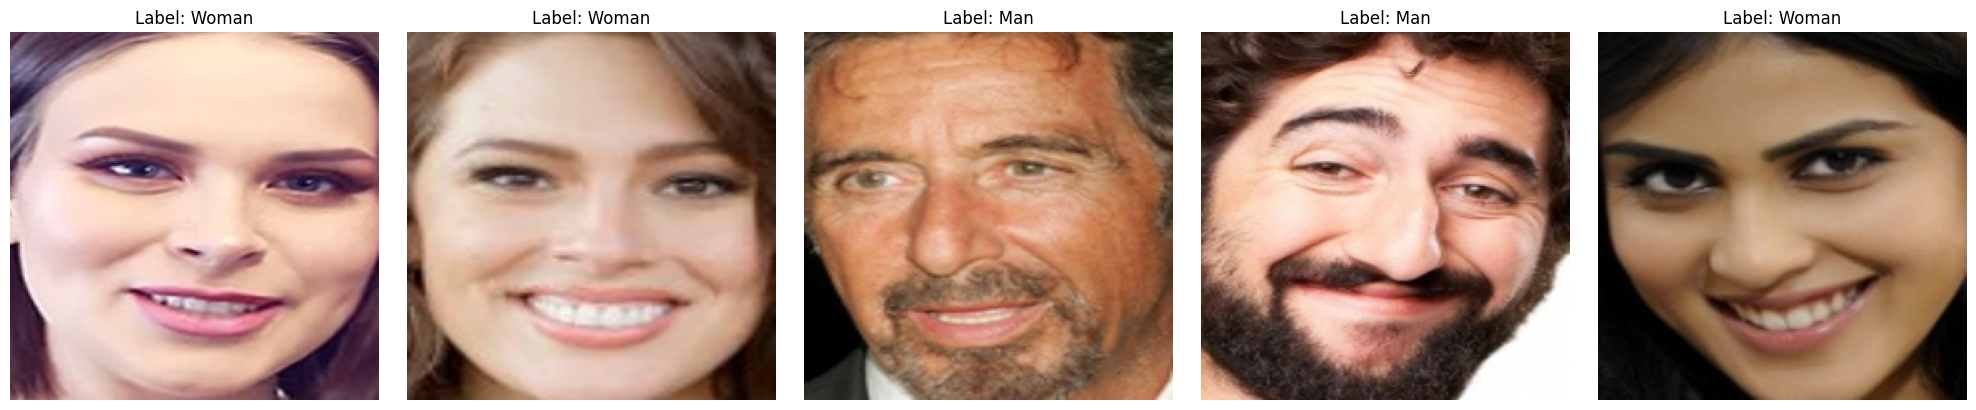

In [4]:
def plot_random_samples(X_train, y_train, n_samples=5, figsize=(20, 4)):
    indices = np.random.choice(range(len(X_train)), n_samples, replace=False)

    fig, axes = plt.subplots(1, n_samples, figsize=figsize)

    for idx, ax in enumerate(axes):
        img_path = X_train[indices[idx]]
        label = y_train[indices[idx]]
        img = cv2.imread(img_path)
        img = cv2.resize(img, (224, 224))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f'Label: {"Man" if label == 0 else "Woman"}')
    
    plt.tight_layout()
    plt.show()

plot_random_samples(X_train, y_train)

<h2 id='Preprocessing'>Preprocessing</h2>

<h4> Image Features & Preprocessing </h4>

In [5]:
class Image:
    def __init__(self, image):
        self.image = self.preprocessImage(image)
        #Basics features
        self.colorChannelsRGB = self.extractColorChannelsRGB()
        self.RGBMean = self.calculateRGBMean()
        self.RGBMode = self.calculateRGBMode()
        self.RGBVariance = self.calculateRGBVariance()
        self.RGBStandardDeviation = self.calculateRGBStandardDeviation()
        self.colorHistogram = self.calculateColorHistogram()
        #Advanced features
        self.grayLevelCooccurrenceMatrixProperties = self.calculateGrayLevelCooccurrenceMatrixProperties()
        self.histogramOfOrientedGradients = self.calculateHistogramOfOrientedGradients()
        self.peakLocalMax = self.calculatePeakLocalMax()
        self.huMoments = self.getHuMoments()
        self.edgeDensity = self.calculateEdgeDensity()
        self.imageEntropy = self.calculateImageEntropy()
        self.laplacianMeanStd = self.calculateLaplacianMeanStd()
        self.aspectRatio = self.calculateAspectRatio()
        self.circularity = self.calculateCircularity()
        #Feature vector
        self.featureVector = self.generateFeatureVector()

    def preprocessImage(self, image):
        image = cv2.resize(image, (128, 128))
        return image

    def extractColorChannelsRGB(self):
        redChannel = self.image[:,:,0]
        greenChannel = self.image[:,:,1]
        blueChannel = self.image[:,:,2]

        return [redChannel, greenChannel, blueChannel]

    def calculateRGBMean(self):
        redChannel = self.image[:,:,0]
        greenChannel = self.image[:,:,1]
        blueChannel = self.image[:,:,2]
        redMean = np.mean(redChannel)
        greenMean = np.mean(greenChannel)
        blueMean = np.mean(blueChannel)

        return [redMean, greenMean, blueMean]

    def calculateRGBMode(self):
        redChannel = self.image[:,:,0]
        greenChannel = self.image[:,:,1]
        blueChannel = self.image[:,:,2]
        redMode = skimage.exposure.histogram(redChannel)[1].argmax()
        greenMode = skimage.exposure.histogram(greenChannel)[1].argmax()
        blueMode = skimage.exposure.histogram(blueChannel)[1].argmax()

        return [redMode, greenMode, blueMode]

    def calculateRGBVariance(self):
        redChannel = self.image[:,:,0]
        greenChannel = self.image[:,:,1]
        blueChannel = self.image[:,:,2]
        redVariance = np.var(redChannel.flatten())
        greenVariance = np.var(greenChannel.flatten())
        blueVariance = np.var(blueChannel.flatten())

        return [redVariance, greenVariance, blueVariance]

    def calculateRGBStandardDeviation(self):
        redChannel = self.image[:,:,0]
        greenChannel = self.image[:,:,1]
        blueChannel = self.image[:,:,2]
        redStandardDeviation = np.std(redChannel)
        greenStandardDeviation = np.std(greenChannel)
        blueStandardDeviation = np.std(blueChannel)

        return [redStandardDeviation, greenStandardDeviation, blueStandardDeviation]

    def calculateColorHistogram(self):
        image = self.image
        bins = 256
        # Calculate the histogram for each channel
        histogram = [cv2.calcHist([image], [i], None, [bins], [0, 256]) for i in range(3)]
        # Normalize the histograms
        histogram = [cv2.normalize(hist, hist).flatten() for hist in histogram]

        return histogram

    def calculateGrayLevelCooccurrenceMatrixProperties(self):
        image_gray = skimage.color.rgb2gray(self.image)
        image_gray_u8 = (image_gray * 255).astype(np.uint8)
        glcm = skimage.feature.graycomatrix(image_gray_u8, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
        contrast = skimage.feature.graycoprops(glcm, 'contrast')[0, 0]
        dissimilarity = skimage.feature.graycoprops(glcm, 'dissimilarity')[0, 0]
        homogeneity = skimage.feature.graycoprops(glcm, 'homogeneity')[0, 0]
        energy = skimage.feature.graycoprops(glcm, 'energy')[0, 0]
        correlation = skimage.feature.graycoprops(glcm, 'correlation')[0, 0]

        return [contrast, dissimilarity, homogeneity, energy, correlation]

    def calculateHistogramOfOrientedGradients(self):
        image_gray = skimage.color.rgb2gray(self.image)

        return skimage.feature.hog(image_gray, pixels_per_cell=(16, 16), cells_per_block=(1, 1), orientations=9, visualize=False)

    def calculatePeakLocalMax(self):
        image_gray = skimage.color.rgb2gray(self.image)

        return skimage.feature.peak_local_max(image_gray, min_distance=1, threshold_abs=0.1, num_peaks=10)

    def getHuMoments(self):
        image_gray = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
        image_gray = cv2.GaussianBlur(image_gray, (5, 5), 0)
        _, image_gray = cv2.threshold(image_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        moments = cv2.moments(image_gray)
        huMoments = cv2.HuMoments(moments)

        return huMoments

    def calculateEdgeDensity(self):
        edges = cv2.Canny(self.image, 100, 200)
        edge_density = np.sum(edges > 0) / (self.image.shape[0] * self.image.shape[1])
        return edge_density

    def calculateImageEntropy(self):
        gray_image = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
        hist, _ = np.histogram(gray_image, bins=256, range=(0, 256), density=True)
        hist = hist[hist > 0]
        entropy = -np.sum(hist * np.log2(hist))
        return entropy

    def calculateLaplacianMeanStd(self):
        gray_image = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
        laplacian = cv2.Laplacian(gray_image, cv2.CV_64F)
        return [np.mean(laplacian), np.std(laplacian)]

    def calculateAspectRatio(self):
        h, w, _ = self.image.shape
        return w / h

    def calculateCircularity(self):
        gray_image = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            cnt = max(contours, key=cv2.contourArea)
            area = cv2.contourArea(cnt)
            perimeter = cv2.arcLength(cnt, True)
            if perimeter > 0:
                circularity = (4 * np.pi * area) / (perimeter ** 2)
                return circularity
        return 0.0

    def generateFeatureVector(self):
        featureVector = np.array([])

        featureVector = np.append(featureVector, self.RGBMean)
        featureVector = np.append(featureVector, self.RGBMode)
        featureVector = np.append(featureVector, self.RGBVariance)
        featureVector = np.append(featureVector, self.RGBStandardDeviation)
        featureVector = np.append(featureVector, np.concatenate([ histogram.flatten() for histogram in self.colorHistogram ]))
        featureVector = np.append(featureVector, self.grayLevelCooccurrenceMatrixProperties)
        featureVector = np.append(featureVector, self.histogramOfOrientedGradients)
        featureVector = np.append(featureVector, self.peakLocalMax)
        featureVector = np.append(featureVector, self.huMoments)
        featureVector = np.append(featureVector, self.edgeDensity)
        featureVector = np.append(featureVector, self.imageEntropy)
        featureVector = np.append(featureVector, self.laplacianMeanStd)
        featureVector = np.append(featureVector, self.aspectRatio)
        featureVector = np.append(featureVector, self.circularity)

        return featureVector

<h4> Feature Extraction </h4>

In [6]:
def prepare_features(X_paths, y_labels):
    features = []
    
    for img_path in tqdm(X_paths, desc="Processing images"):
        try:
            image = cv2.imread(img_path)
            if image is None:
                print(f"Error loading image: {img_path}")
                continue
                
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            img_processor = Image(image)
            features.append(img_processor.featureVector)
            
        except Exception as e:
            print(f"Error processing image {img_path}: {str(e)}")
            continue
    
    return np.array(features), np.array(y_labels)

X_train_features, y_train = prepare_features(X_train, y_train)
X_test_features, y_test = prepare_features(X_test, y_test)

scaler = StandardScaler()
X_train_features = scaler.fit_transform(X_train_features)
X_test_features = scaler.transform(X_test_features)

print(f'X_train_features shape: {X_train_features.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test_features shape: {X_test_features.shape}')
print(f'y_test shape: {y_test.shape}')

Processing images: 100%|██████████| 462/462 [00:03<00:00, 126.02it/s]

X_train_features shape: (1845, 1394)
y_train shape: (1845,)
X_test_features shape: (462, 1394)
y_test shape: (462,)


<h2 id='Modeling'>Modeling</h2>
SVM from sklearn library will be used for the grid search.

<h2 id='Training'>Training</h2>
Grid Search to find the best hyperparameters for the SVM model.

In [7]:
param_grid = {
    'C': [0.0001, 0.001, 0.01, 0.1],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto', 0.1, 1]
}

total_combinations = len(param_grid['C']) * len(param_grid['kernel']) * len(param_grid['gamma'])

best_params = None
best_model = None
best_test_accuracy = 0
results = []

pbar = tqdm(total=total_combinations, desc="Grid Search Progress")

# En la parte del grid search
for C in param_grid['C']:
    for kernel in param_grid['kernel']:
        for gamma in param_grid['gamma']:
            try:
                # Entrenar modelo
                model = SVC(C=C, kernel=kernel, gamma=gamma)
                model.fit(X_train_features, y_train)

                train_predictions = model.predict(X_train_features)
                train_accuracy = accuracy_score(y_train, train_predictions)
                train_precision = precision_score(y_train, train_predictions, zero_division=1)
                train_recall = recall_score(y_train, train_predictions, zero_division=1)
                train_f1 = f1_score(y_train, train_predictions, zero_division=1)

                test_predictions = model.predict(X_test_features)
                test_accuracy = accuracy_score(y_test, test_predictions)
                test_precision = precision_score(y_test, test_predictions, zero_division=1)
                test_recall = recall_score(y_test, test_predictions, zero_division=1)
                test_f1 = f1_score(y_test, test_predictions, zero_division=1)

                results.append({
                    'C': C,
                    'kernel': kernel,
                    'gamma': gamma,
                    'train_accuracy': train_accuracy,
                    'train_precision': train_precision,
                    'train_recall': train_recall,
                    'train_f1': train_f1,
                    'test_accuracy': test_accuracy,
                    'test_precision': test_precision,
                    'test_recall': test_recall,
                    'test_f1': test_f1,
                    'diff_accuracy': train_accuracy - test_accuracy,
                    'n_support_vectors': model.n_support_.sum()  
                })

                if test_accuracy > best_test_accuracy:
                    best_test_accuracy = test_accuracy
                    best_model = model
                    best_params = {'C': C, 'kernel': kernel, 'gamma': gamma}

            except Exception as e:
                print(f"\nError with parameters C={C}, kernel={kernel}, gamma={gamma}: {str(e)}")
            
            pbar.update(1)

pbar.close()

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('test_accuracy', ascending=False)

results_df.to_csv('Results/SVM/grid_search_results_svm.csv', index=False)

joblib.dump(best_model, 'Models/best_svm_model.pkl')
joblib.dump(scaler, 'Models/svm_scaler.pkl')

print("\nBest Model and scaler saved successfully!")

results_df

Grid Search Progress: 100%|██████████| 32/32 [01:25<00:00,  2.67s/it]


Best Model and scaler saved successfully!


,C,kernel,gamma,train_accuracy,train_precision,train_recall,train_f1,test_accuracy,test_precision,test_recall,test_f1,diff_accuracy,n_support_vectors
8,0.0010,linear,scale,0.951762,0.960586,0.940463,0.950418,0.898268,0.916667,0.872247,0.893905,0.053493,665
9,0.0010,linear,auto,0.951762,0.960586,0.940463,0.950418,0.898268,0.916667,0.872247,0.893905,0.053493,665
10,0.0010,linear,0.1,0.951762,0.960586,0.940463,0.950418,0.898268,0.916667,0.872247,0.893905,0.053493,665
11,0.0010,linear,1,0.951762,0.960586,0.940463,0.950418,0.898268,0.916667,0.872247,0.893905,0.053493,665
16,0.0100,linear,scale,0.990786,0.993348,0.987872,0.990603,0.883117,0.891403,0.867841,0.879464,0.107669,518
19,0.0100,linear,1,0.990786,0.993348,0.987872,0.990603,0.883117,0.891403,0.867841,0.879464,0.107669,518
18,0.0100,linear,0.1,0.990786,0.993348,0.987872,0.990603,0.883117,0.891403,0.867841,0.879464,0.107669,518
17,0.0100,linear,auto,0.990786,0.993348,0.987872,0.990603,0.883117,0.891403,0.867841,0.879464,0.107669,518
27,0.1000,linear,1,1.000000,1.000000,1.000000,1.000000,0.872294,0.875000,0.863436,0.869180,0.127706,496
26,0.1000,linear,0.1,1.000000,1.000000,1.000000,1.000000,0.872294,0.875000,0.863436,0.869180,0.127706,496


<h2 id='Evaluation'>Evaluation</h2>

Best model evaluation:


Best Model Performance:

Parameters:
C: 0.001
kernel: linear
gamma: scale

Training Metrics:
Accuracy: 0.9518
Precision: 0.9606
Recall: 0.9405
F1-Score: 0.9504

Test Metrics:
Accuracy: 0.8983
Precision: 0.9167
Recall: 0.8722
F1-Score: 0.8939


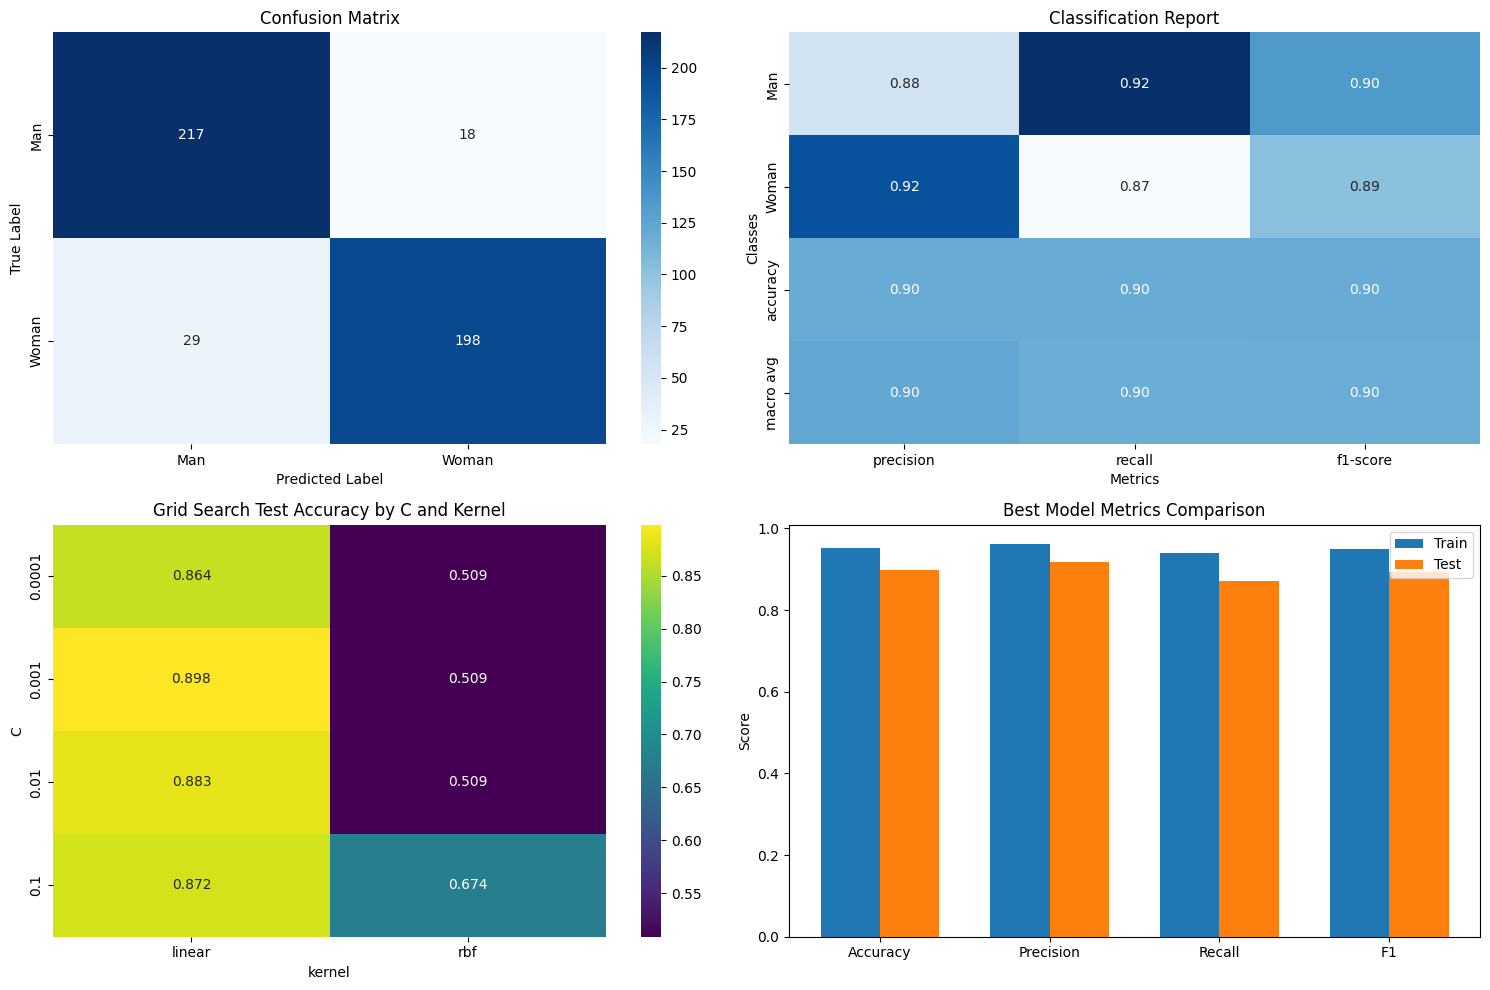

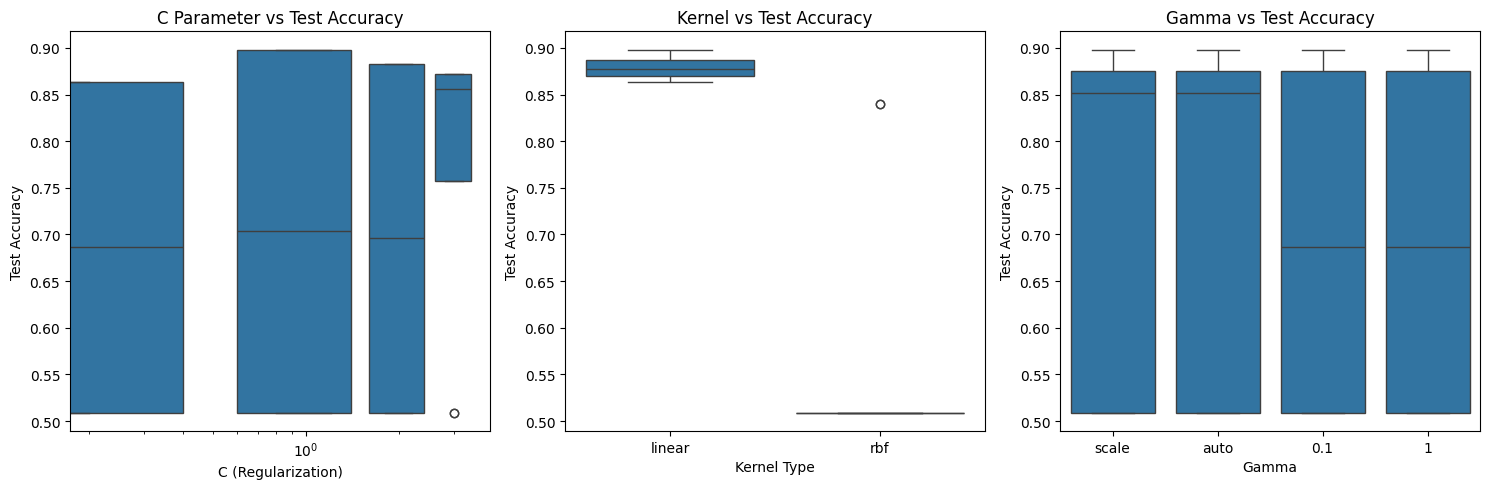

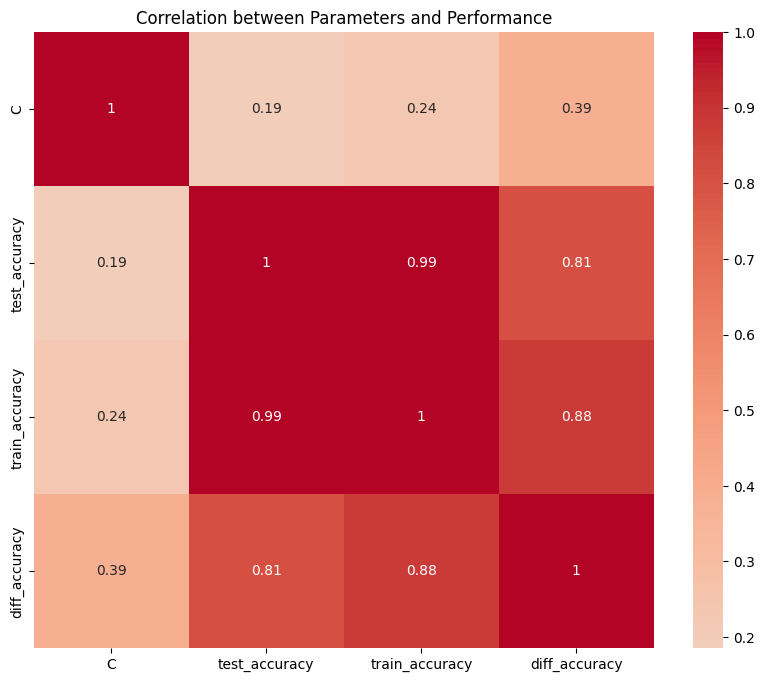

In [8]:
print("\nBest Model Performance:")
print("\nParameters:")
for param, value in best_params.items():
    print(f"{param}: {value}")

print("\nTraining Metrics:")
print(f"Accuracy: {results_df.iloc[0]['train_accuracy']:.4f}")
print(f"Precision: {results_df.iloc[0]['train_precision']:.4f}")
print(f"Recall: {results_df.iloc[0]['train_recall']:.4f}")
print(f"F1-Score: {results_df.iloc[0]['train_f1']:.4f}")

print("\nTest Metrics:")
print(f"Accuracy: {results_df.iloc[0]['test_accuracy']:.4f}")
print(f"Precision: {results_df.iloc[0]['test_precision']:.4f}")
print(f"Recall: {results_df.iloc[0]['test_recall']:.4f}")
print(f"F1-Score: {results_df.iloc[0]['test_f1']:.4f}")

y_pred = best_model.predict(X_test_features)

conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, target_names=['Man', 'Woman'], output_dict=True)

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Man', 'Woman'], 
            yticklabels=['Man', 'Woman'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(2, 2, 2)
class_report_df = pd.DataFrame(class_report).transpose()
sns.heatmap(class_report_df.iloc[:-1, :-1], annot=True, fmt='.2f', 
            cmap='Blues', cbar=False)
plt.title('Classification Report')
plt.xlabel('Metrics')
plt.ylabel('Classes')

plt.subplot(2, 2, 3)
pivot_table = results_df.pivot_table(
    values='test_accuracy',
    index='C',
    columns='kernel',
    aggfunc='mean'
)
sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap="viridis")
plt.title('Grid Search Test Accuracy by C and Kernel')

plt.subplot(2, 2, 4)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
train_scores = [results_df.iloc[0]['train_' + m.lower()] for m in metrics]
test_scores = [results_df.iloc[0]['test_' + m.lower()] for m in metrics]

x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, train_scores, width, label='Train')
plt.bar(x + width/2, test_scores, width, label='Test')
plt.xticks(x, metrics)
plt.ylabel('Score')
plt.title('Best Model Metrics Comparison')
plt.legend()

plt.tight_layout()
plt.savefig('Results/SVM/svm_results.png')
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.boxplot(x='C', y='test_accuracy', data=results_df, ax=axes[0])
axes[0].set_title('C Parameter vs Test Accuracy')
axes[0].set_xscale('log')
axes[0].set_xlabel('C (Regularization)')
axes[0].set_ylabel('Test Accuracy')

sns.boxplot(x='kernel', y='test_accuracy', data=results_df, ax=axes[1])
axes[1].set_title('Kernel vs Test Accuracy')
axes[1].set_xlabel('Kernel Type')
axes[1].set_ylabel('Test Accuracy')

sns.boxplot(x='gamma', y='test_accuracy', data=results_df, ax=axes[2])
axes[2].set_title('Gamma vs Test Accuracy')
axes[2].set_xlabel('Gamma')
axes[2].set_ylabel('Test Accuracy')

plt.tight_layout()
plt.savefig('Results/SVM/hyperparameters_metrics_svm.png')
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Man', 'Woman'], 
            yticklabels=['Man', 'Woman'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('Results/SVM/confusion_matrix_svm.png')
plt.close()

with open('Results/SVM/svm_results.txt', 'w') as f:
    f.write("Best Model Performance\n\n")
    f.write("Parameters:\n")
    for param, value in best_params.items():
        f.write(f"{param}: {value}\n")
    
    f.write("\nTraining Metrics:\n")
    f.write(f"Accuracy: {results_df.iloc[0]['train_accuracy']:.4f}\n")
    f.write(f"Precision: {results_df.iloc[0]['train_precision']:.4f}\n")
    f.write(f"Recall: {results_df.iloc[0]['train_recall']:.4f}\n")
    f.write(f"F1-Score: {results_df.iloc[0]['train_f1']:.4f}\n")
    
    f.write("\nTest Metrics:\n")
    f.write(f"Accuracy: {results_df.iloc[0]['test_accuracy']:.4f}\n")
    f.write(f"Precision: {results_df.iloc[0]['test_precision']:.4f}\n")
    f.write(f"Recall: {results_df.iloc[0]['test_recall']:.4f}\n")
    f.write(f"F1-Score: {results_df.iloc[0]['test_f1']:.4f}\n")
    
    f.write("\nConfusion Matrix:\n")
    f.write(str(conf_matrix))
    
    f.write("\n\nClassification Report:\n")
    f.write(classification_report(y_test, y_pred, target_names=['Man', 'Woman']))

numeric_cols = ['C', 'test_accuracy', 'train_accuracy', 'diff_accuracy']
correlation_matrix = results_df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation between Parameters and Performance')
plt.savefig('Results/SVM/correlation_analysis_svm.png')
plt.show()

<h2 id='Testing'>Testing</h2>
Testing the best model on the test dataset:

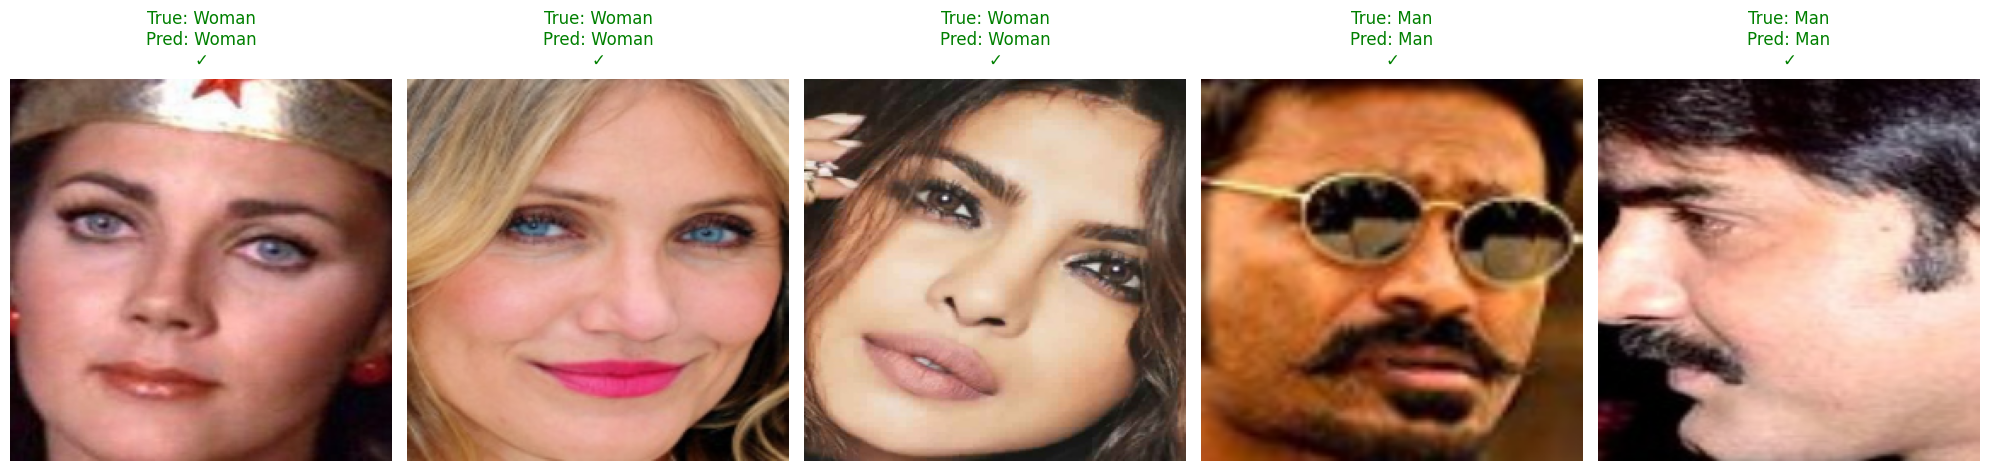

In [9]:
random_indices = np.random.choice(range(len(X_test)), 5, replace=False)
fig, axes = plt.subplots(1, 5, figsize=(20, 20))

for i, ax in enumerate(axes):
    try:
        idx = random_indices[i]

        img_path = X_test[idx]
        img = cv2.imread(img_path)
        if img is None:
            print(f"Error loading image: {img_path}")
            continue
            
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        image = Image(img)
        feature_vector = image.featureVector.reshape(1, -1)
        feature_vector_scaled = scaler.transform(feature_vector)

        predicted_label = best_model.predict(feature_vector_scaled)[0]
        true_label = y_test[idx]
        
        is_correct = predicted_label == true_label
        color = 'green' if is_correct else 'red'

        ax.imshow(cv2.resize(img, (224, 224)))
        ax.axis('off')
        
        title = f"True: {'Man' if true_label == 0 else 'Woman'}\n"
        title += f"Pred: {'Man' if predicted_label == 0 else 'Woman'}\n"
        title += f"{'✓' if is_correct else '✗'}"
        
        ax.set_title(title, color=color, fontsize=12, pad=10)
        
    except Exception as e:
        print(f"Error processing image at index {idx}: {str(e)}")
        continue

plt.tight_layout()
plt.show()